# P4J Regression demo

A simple demonstration of P4J's robust regression routine

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import time
params = {
    'axes.labelsize': 16,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'axes.titlesize': 18,
    'font.family': 'serif',
    'text.usetex': False
   }
plt.rcParams.update(params)
import P4J

## Generating a simple synthetic light curve
We create an irregulary sampled time series using a harmonic model composed of three sine waves with an specified Signal to Noise Ratio SNR)

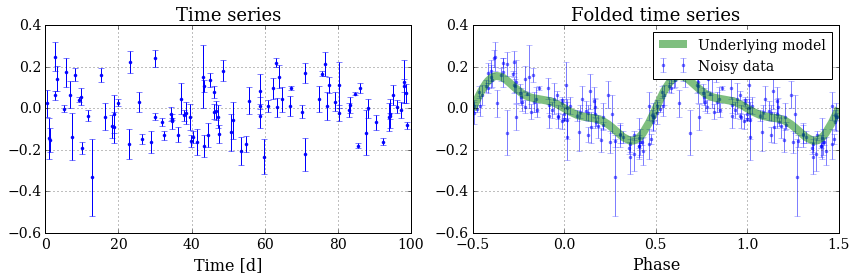

In [2]:
f0=2.0
lc_generator = P4J.synthetic_light_curve_generator(T=100.0, N=100)
lc_generator.set_model(f0=f0, A=[1.0, 0.5, 0.25])

t, y, s = lc_generator.draw_noisy_time_series(SNR=3.0, red_noise_ratio=0.25, outlier_ratio=0.0)
_, yc = lc_generator.get_clean_signal()

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.errorbar(t, y, s, fmt='.')
ax.set_xlabel('Time [d]')
ax.set_title('Time series')
plt.grid()
ax = fig.add_subplot(1, 2, 2)
phase = np.mod(t, 1/f0)*f0
index = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
            np.concatenate([y[index], y[index]]), 
            np.concatenate([s[index], s[index]]), fmt='.', alpha=0.5, label='Noisy data')
ax.plot(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
        np.concatenate([yc[index], yc[index]]), 
        linewidth=8, alpha=0.5, label='Underlying model')
plt.legend()
ax.set_xlabel('Phase')
ax.set_title('Folded time series')
plt.grid()
plt.tight_layout()

## Recovering the underlying model from the data

Let's try to recover the clean underlying model from the noisy data, assumming that we know the fundamental frequency (f0). In this demo we compare the Weighted Maximum Correntropy Criterion (WMCC) with the broadly used Weighted Least Squares (WLS) criterion.

Normalized Mean Squared Error (NMSE) of the fit:
WLS: 0.057540
WMCC: 0.028778


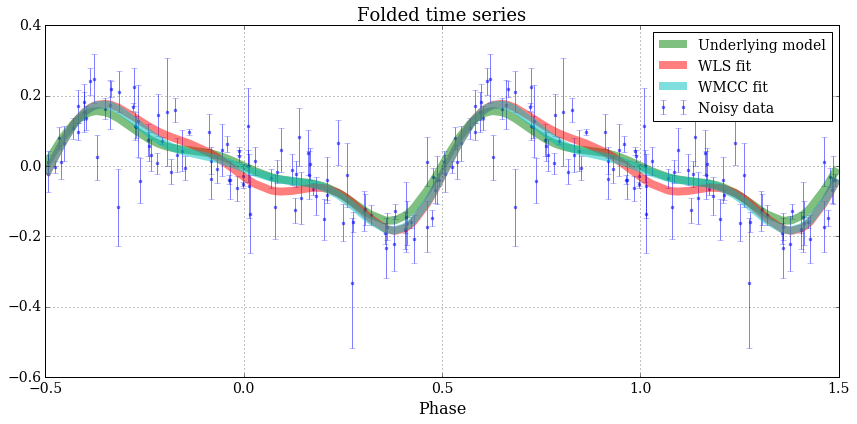

In [3]:
def NMSE(y_estimated, y_target):
    return np.sum(np.power(y_target - y_estimated, 2.0))/np.sum(np.power(y_target - np.mean(y_target), 2.0))

# We consider a harmonic dictionary with 3 components
Phi = P4J.harmonic_dictionary(t, f0, M=3)
# Data fitting
beta_WLS, cost = P4J.find_beta_WLS(y, Phi, s)
model_WLS = np.dot(Phi, beta_WLS)
beta_WMCC, cost  = P4J.find_beta_WMCC(y, Phi, s)
model_WMCC = np.dot(Phi, beta_WMCC)
print("Normalized Mean Squared Error (NMSE) of the fit:")
print("WLS: %f" % (NMSE(yc, model_WLS)))
print("WMCC: %f" % (NMSE(yc, model_WMCC)))

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
phase = np.mod(t, 1/f0)*f0
index = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
            np.concatenate([y[index], y[index]]), 
            np.concatenate([s[index], s[index]]), fmt='.', alpha=0.5, label='Noisy data')
ax.plot(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
        np.concatenate([yc[index], yc[index]]), 
        linewidth=8, alpha=0.5, label='Underlying model')
ax.plot(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
        np.concatenate([model_WLS[index], model_WLS[index]]), 
        linewidth=8, alpha=0.5, label='WLS fit')
ax.plot(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
        np.concatenate([model_WMCC[index], model_WMCC[index]]), 
        linewidth=8, alpha=0.5, label='WMCC fit')
plt.legend()
ax.set_xlabel('Phase')
ax.set_title('Folded time series')
plt.grid()
plt.tight_layout()

Now let's compute the average NMSE over 100 noisy realizations

In [4]:
NMSE_mat = np.zeros(shape=(500, 2))
Phi = P4J.harmonic_dictionary(t, f0, M=3)
for k in range(0, 500):
    t, y, s = lc_generator.draw_noisy_time_series(SNR=3.0, red_noise_ratio=0.25, outlier_ratio=0.0)
    _, yc = lc_generator.get_clean_signal()
    beta_WLS, cost = P4J.find_beta_WLS(y, Phi, s)
    model_WLS = np.dot(Phi, beta_WLS)
    beta_WMCC, cost = P4J.find_beta_WMCC(y, Phi, s)
    model_WMCC = np.dot(Phi, beta_WMCC)
    NMSE_mat[k, 0] = NMSE(yc, model_WLS)
    NMSE_mat[k, 1] = NMSE(yc, model_WMCC)
print("NMSE of the fit")
print("WLS  mean: %f std: %f" %(np.mean(NMSE_mat, axis=0)[0], np.std(NMSE_mat, axis=0)[0]))
print("WMCC mean: %f std: %f" %(np.mean(NMSE_mat, axis=0)[1], np.std(NMSE_mat, axis=0)[1]))

NMSE of the fit
WLS  mean: 0.035921 std: 0.021863
WMCC mean: 0.022430 std: 0.011885
